# Model 1: SPAM Classifier 

## Data preparation

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from collections import Counter
import re

In [5]:
data1 = pd.read_csv('../../data/youtube_spam_collection_dataset/Youtube01-Psy.csv')
data2 = pd.read_csv('../../data/youtube_spam_collection_dataset/Youtube02-KatyPerry.csv')
data3 = pd.read_csv('../../data/youtube_spam_collection_dataset/Youtube03-LMFAO.csv')
data4 = pd.read_csv('../../data/youtube_spam_collection_dataset/Youtube04-Eminem.csv')
data5 = pd.read_csv('../../data/youtube_spam_collection_dataset/Youtube05-Shakira.csv')
data = pd.concat([data1, data2, data3, data4, data5], ignore_index=True)
data = data[['CONTENT', 'CLASS']]

In [3]:
data.head()

,CONTENT,CLASS
0,"Huh, anyway check out this you[tube] channel: ...",1
1,Hey guys check out my new channel and our firs...,1
2,just for test I have to say murdev.com,1
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1


In [4]:
len(data)

1956

In [5]:
data.isna().sum()

CONTENT    0
CLASS      0
dtype: int64

In [6]:
data['CLASS'].value_counts()

CLASS
1    1005
0     951
Name: count, dtype: int64

## Data Visualization

C:\Users\davyd\AppData\Local\Temp\ipykernel_22572\2495039947.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="CLASS", data=data, palette="coolwarm")


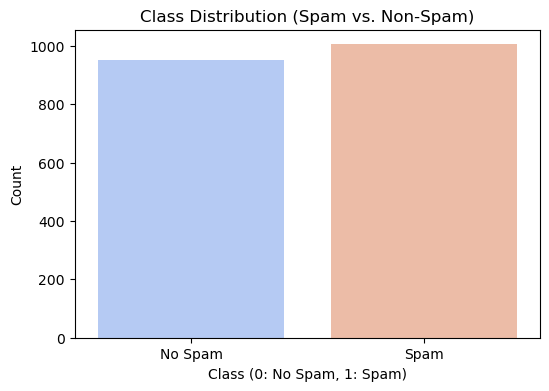

In [7]:
# 1. Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x="CLASS", data=data, palette="coolwarm")
plt.title("Class Distribution (Spam vs. Non-Spam)")
plt.xlabel("Class (0: No Spam, 1: Spam)")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=['No Spam', 'Spam'])
plt.show()

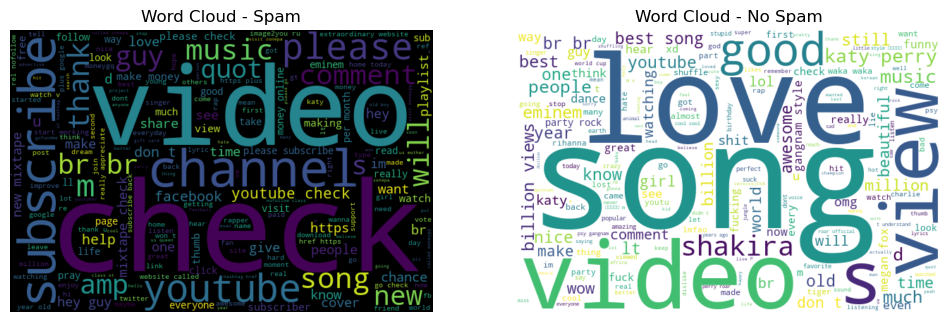

In [8]:
# 2. Word Clouds for Spam and Non-Spam
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)  # Remove non-word characters
    return text

spam_text = " ".join(data[data["CLASS"] == 1]["CONTENT"].apply(preprocess_text))
no_spam_text = " ".join(data[data["CLASS"] == 0]["CONTENT"].apply(preprocess_text))

wordcloud_spam = WordCloud(width=600, height=400, background_color="black").generate(spam_text)
wordcloud_no_spam = WordCloud(width=600, height=400, background_color="white").generate(no_spam_text)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_spam, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Spam")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_no_spam, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - No Spam")

plt.show()


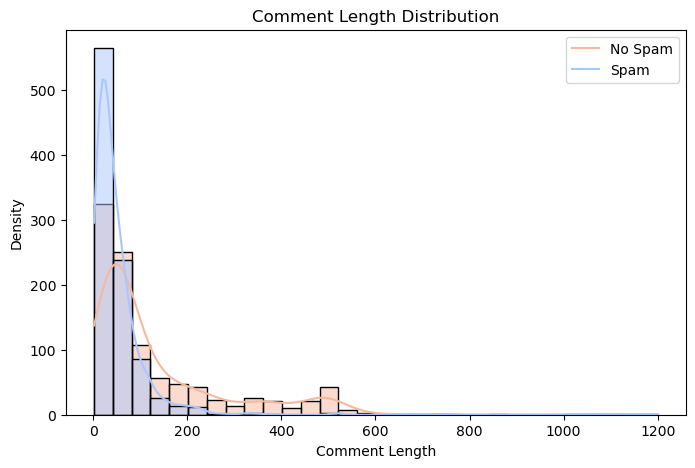

In [9]:
# 3. Comment Length Distribution
data["COMMENT_LENGTH"] = data["CONTENT"].apply(lambda x: len(str(x)))

plt.figure(figsize=(8, 5))
sns.histplot(data, x="COMMENT_LENGTH", hue="CLASS", bins=30, kde=True, palette="coolwarm")
plt.title("Comment Length Distribution")
plt.xlabel("Comment Length")
plt.ylabel("Density")
plt.legend(["No Spam", "Spam"])
plt.show()

We can notice that the sentences with spam is much shorter than the sentences with no spam. 

C:\Users\davyd\AppData\Local\Temp\ipykernel_22572\2020103782.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=spam_df["Word"], x=spam_df["Count"], palette="Reds_r")
C:\Users\davyd\AppData\Local\Temp\ipykernel_22572\2020103782.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=no_spam_df["Word"], x=no_spam_df["Count"], palette="Blues_r")


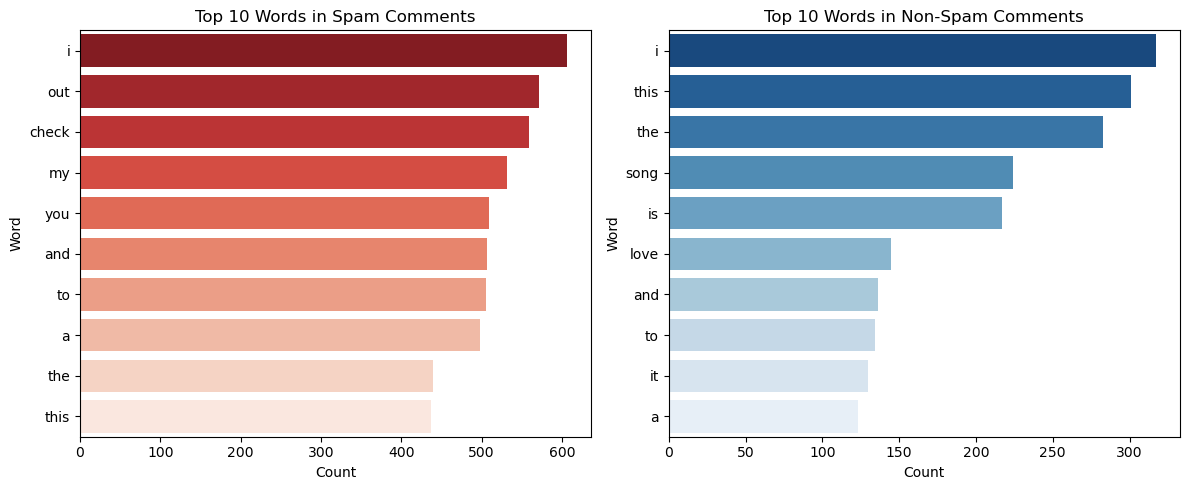

In [10]:
# 4. Most Common Words in Spam and Non-Spam
def get_most_common_words(text, num_words=10):
    words = text.split()
    return Counter(words).most_common(num_words)

spam_words = get_most_common_words(spam_text)
no_spam_words = get_most_common_words(no_spam_text)

spam_df = pd.DataFrame(spam_words, columns=["Word", "Count"])
no_spam_df = pd.DataFrame(no_spam_words, columns=["Word", "Count"])

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.barplot(y=spam_df["Word"], x=spam_df["Count"], palette="Reds_r")
plt.title("Top 10 Words in Spam Comments")

plt.subplot(1, 2, 2)
sns.barplot(y=no_spam_df["Word"], x=no_spam_df["Count"], palette="Blues_r")
plt.title("Top 10 Words in Non-Spam Comments")

plt.tight_layout()
plt.show()

## Build Naive Bayes model

In [7]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [12]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(data["CONTENT"])
y = data["CLASS"]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
nb_model = MultinomialNB()
param_grid = {
    "alpha": [0.1, 0.5, 1.0, 2.0, 5.0] 
}
grid_search = GridSearchCV(nb_model, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train, y_train)
best_nb_model = grid_search.best_estimator_

## Evaluate the model

In [15]:
y_pred = best_nb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

Model Accuracy: 0.9260


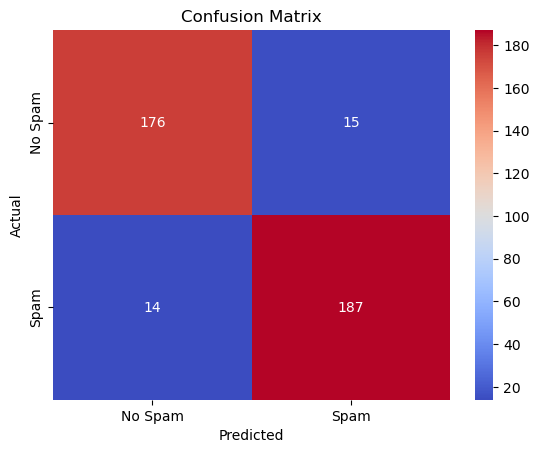

In [16]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm", xticklabels=["No Spam", "Spam"], yticklabels=["No Spam", "Spam"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [17]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.92      0.92       191
           1       0.93      0.93      0.93       201

    accuracy                           0.93       392
   macro avg       0.93      0.93      0.93       392
weighted avg       0.93      0.93      0.93       392



Model shows good performance with 92% accuracy. But we can find some false positives and false negatives predictions. It is to important to improve recall metric, because we don't want to classify a spam sentence as no spam. So find some ways to improve recall metric is important.

## Improve the model

Try to use XGBoost model instead of Naive Bayes model maybe it will show better performance.

In [23]:
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from tqdm import tqdm
import time

In [19]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=5000) 
X = vectorizer.fit_transform(data["CONTENT"])
y = data["CLASS"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
smote = SMOTE(sampling_strategy=1.0, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
xgb_model = xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss", use_label_encoder=False)
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}
class TQDMGridSearchCV(GridSearchCV):
    def fit(self, X, y=None, **fit_params):
        with tqdm(total=len(self.param_grid["n_estimators"]) * 
                         len(self.param_grid["max_depth"]) * 
                         len(self.param_grid["learning_rate"]) * 
                         len(self.param_grid["subsample"]) * 
                         len(self.param_grid["colsample_bytree"])) as pbar:
            def callback(_):
                pbar.update(1)
            start_time = time.time()
            result = super().fit(X, y, **fit_params)
            end_time = time.time()
            print(f"\nTraining completed in {end_time - start_time:.2f} seconds")
            return result
grid_search = TQDMGridSearchCV(xgb_model, param_grid, cv=5, scoring="recall", n_jobs=-1, verbose=0)
grid_search.fit(X_train_resampled, y_train_resampled)
best_xgb = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

  0%|          | 0/48 [00:00<?, ?it/s]c:\Users\davyd\miniconda3\envs\PYTHON3.10\lib\site-packages\xgboost\core.py:158: UserWarning: [13:01:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
  0%|          | 0/48 [00:36<?, ?it/s]


Training completed in 36.17 seconds
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}


In [38]:
y_pred = best_xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9439


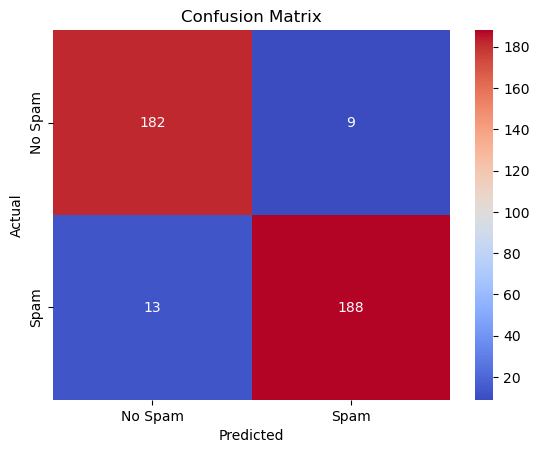

In [39]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm", xticklabels=["No Spam", "Spam"], yticklabels=["No Spam", "Spam"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       191
           1       0.95      0.94      0.94       201

    accuracy                           0.94       392
   macro avg       0.94      0.94      0.94       392
weighted avg       0.94      0.94      0.94       392



New model showed a better performance with 95% accuracy. So build final model on the whole dataset and save it.

## Build final model

In [24]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=5000)  
X = vectorizer.fit_transform(data["CONTENT"])  
y = data["CLASS"]
smote = SMOTE(sampling_strategy=1.0, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
xgb_model = xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss", use_label_encoder=False)
param_grid = {
    "n_estimators": [100, 200], 
    "max_depth": [3, 5], 
    "learning_rate": [0.05, 0.1],  
    "subsample": [0.8, 1.0],  
    "colsample_bytree": [0.8, 1.0] 
}
class TQDMGridSearchCV(GridSearchCV):
    def fit(self, X, y=None, **fit_params):
        total_combinations = (len(self.param_grid["n_estimators"]) * 
                              len(self.param_grid["max_depth"]) * 
                              len(self.param_grid["learning_rate"]) * 
                              len(self.param_grid["subsample"]) * 
                              len(self.param_grid["colsample_bytree"]))
        
        with tqdm(total=total_combinations, desc="GridSearch Progress") as pbar:
            def callback(_): 
                pbar.update(1)
            
            start_time = time.time()
            result = super().fit(X, y, **fit_params)
            end_time = time.time()
            
            print(f"\nTraining completed in {end_time - start_time:.2f} seconds")
            return result
print("\nTraining XGBoost with GridSearchCV...")
grid_search = TQDMGridSearchCV(xgb_model, param_grid, cv=5, scoring="recall", n_jobs=-1, verbose=0)
grid_search.fit(X_resampled, y_resampled)
best_xgb = grid_search.best_estimator_
print(f"\nBest XGBoost Parameters: {grid_search.best_params_}")


Training XGBoost with GridSearchCV...


GridSearch Progress:   0%|          | 0/32 [00:00<?, ?it/s]c:\Users\davyd\miniconda3\envs\PYTHON3.10\lib\site-packages\xgboost\core.py:158: UserWarning: [14:52:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
GridSearch Progress:   0%|          | 0/32 [00:37<?, ?it/s]


Training completed in 37.68 seconds

Best XGBoost Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


## Evaluate final model

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
y_pred = best_xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9847


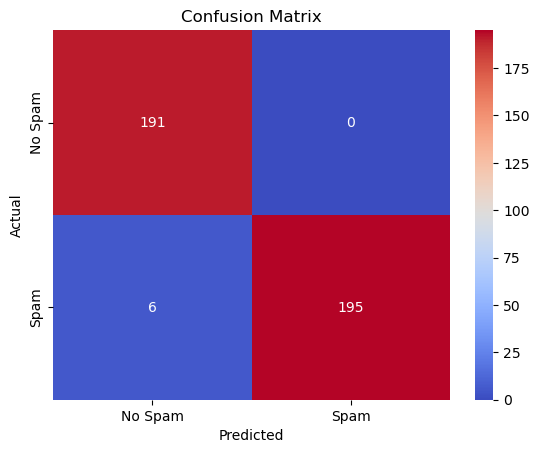

In [34]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm", xticklabels=["No Spam", "Spam"], yticklabels=["No Spam", "Spam"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Save final model

In [40]:
import joblib
joblib.dump(best_xgb, "model1.pkl")
joblib.dump(vectorizer, "vectorizer1.pkl")

['vectorizer1.pkl']

## Test saved model

In [44]:
model1 = joblib.load("model1.pkl")
vectorizer1 = joblib.load("vectorizer1.pkl")
def classify_text(text,model,vectorizer):
    """
    Classifies a given text as Spam (1) or Not Spam (0) using the trained model.
    
    Args:
    text (str): The input text message to classify.
    
    Returns:
    str: "Spam" if classified as spam, otherwise "Not Spam"
    """
    text_transformed = vectorizer.transform([text])
    prediction = model.predict(text_transformed)[0]
    return "Spam" if prediction == 1 else "Not Spam"


sample_text = "Congratulations! You've won a free gift. Click here to claim!"
print(f"Prediction: {classify_text(sample_text,model1,vectorizer1)}")
sample_text2 = "Look my new video please https://www.youtube.com/watch?v=abc123"
print(f"Prediction: {classify_text(sample_text2,model1,vectorizer1)}")

Prediction: Not Spam
Prediction: Spam


# Save vectorizer correctly

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=5000)  
vectorizer.fit_transform(data["CONTENT"])  

<1956x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 38572 stored elements in Compressed Sparse Row format>

In [9]:
import joblib
joblib.dump(vectorizer, "vectorizer_model1.pkl")

['vectorizer_model1.pkl']

In [10]:
from sklearn.exceptions import NotFittedError
import joblib

vectorizer1 = joblib.load("vectorizer_model1.pkl")

try:
    print(vectorizer1.idf_)  # Check if the IDF vector exists
except NotFittedError:
    print("The vectorizer is not fitted.")

[6.63325782 7.48055568 4.81796785 ... 6.09426132 6.7874085  7.19287361]
